In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from matplotlib import pyplot as plt
import cv2

2023-09-19 09:16:24.958872: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Max
2023-09-19 09:16:24.958906: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 96.00 GB
2023-09-19 09:16:24.958910: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 36.00 GB
2023-09-19 09:16:24.959005: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-09-19 09:16:24.959265: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


(9, 4, 9)
tf.Tensor(
[[0.41807854 0.3321671  0.11786185 0.7056771  0.7786438  0.32434836
  0.2606843  0.08196515 0.9274782 ]
 [0.43630365 0.33011767 0.11790462 0.7021074  0.7764692  0.3265587
  0.2557235  0.0865486  0.92281437]
 [0.4336949  0.33051887 0.118026   0.70226365 0.7762031  0.32604775
  0.2561226  0.08594911 0.9234783 ]
 [0.42491382 0.3257398  0.11526955 0.70319897 0.7899291  0.32992107
  0.25900757 0.08282106 0.9283079 ]], shape=(4, 9), dtype=float32)


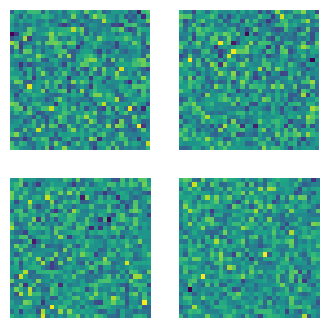

(3, 3, 1, 4)
(1, 32, 32, 4)
(3, 3, 1, 4)
(1, 32, 32, 4)
(3, 3, 1, 4)
(1, 32, 32, 4)
(3, 3, 1, 4)
(1, 32, 32, 4)
(3, 3, 1, 4)
(1, 32, 32, 4)
(3, 3, 1, 4)
(1, 32, 32, 4)
(3, 3, 1, 4)
(1, 32, 32, 4)
(3, 3, 1, 4)
(1, 32, 32, 4)
(3, 3, 1, 4)
(1, 32, 32, 4)
(4, 9, 32, 32, 1)


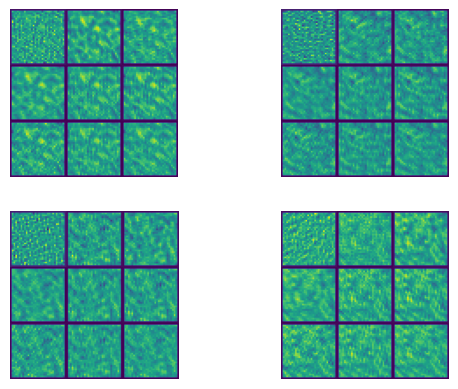

In [2]:
class CustomRNNCell(layers.Layer):
    def __init__(self, filter_size=3, batch_size= 4):
        super(CustomRNNCell, self).__init__()
        self.filter_size = filter_size
        self.dense1 = layers.Dense(128, activation='relu')
        self.dense2 = layers.Dense(filter_size * filter_size, activation='sigmoid')
    
    def call(self, inputs, hidden_state, batch = 4):
        # Apply convolution with the hidden filter state
        #print(inputs.shape)
        # first, the 4x9 hidden state is reshaped to 3x3x4x1
        #print(hidden_state.shape, hidden_state)
        old = hidden_state
        hidden_state = tf.transpose(hidden_state)
        conv_filter = tf.reshape(hidden_state, (self.filter_size, self.filter_size, 1, batch))
        #print(conv_filter.shape, conv_filter)
        # switch inputs from 4x32x32x1 to 1x32x32x4
        inputs = tf.transpose(inputs, perm=[3, 1, 2, 0])
        #print("relevant shapes:")
        #print(inputs.shape)
        #print(conv_filter.shape)
        conv_output = tf.nn.convolution(inputs, conv_filter)
        conv_output = tf.transpose(conv_output, perm=[3, 1, 2, 0])
        #print(conv_output.shape)
        # Flatten the output
        conv_output_flat = tf.reshape(conv_output, (conv_output.shape[0], -1))
        # Pass through dense layers
        dense_output = self.dense1(conv_output_flat)
        new_hidden_state = self.dense2(dense_output)
        return new_hidden_state

class CustomRNN(layers.Layer):
    def __init__(self, timesteps=10, filter_size=3):
        super(CustomRNN, self).__init__()
        self.timesteps = timesteps
        self.rnn_cell = CustomRNNCell(filter_size)

    def call(self, inputs, hidden_state=None):
        #print(inputs.shape)
        #print(hidden_state.shape)
        batch_size = tf.shape(inputs)[0]
        if hidden_state is None:
            hidden_state = tf.zeros((batch_size, 9))

        hidden_seq = []
        hidden_seq.append(hidden_state)
        for t in range(self.timesteps-1):
            hidden_state = self.rnn_cell(inputs[:, t], hidden_state, batch_size)
            hidden_seq.append(hidden_state)
        return tf.convert_to_tensor(hidden_seq)

# Test the RNN layer with random inputs
inputs = tf.random.normal((4, 10, 32, 32, 1))  # Batch of 4 sequences of 10 32x32 images
input_hide = tf.random.normal((4, 9))
rnn_layer = CustomRNN(timesteps=9, filter_size=3)
output = rnn_layer(inputs, input_hide)
output = tf.transpose(output, perm=[0, 1, 2])
print(output.shape)
print(output[-1])

# generate a 4x32x32x1 image
imageBatch = tf.random.normal((1, 32, 32, 4))
# show the 4 images in a 2x2 grid
plt.figure(figsize=(4, 4))
for i in range(4):
    ax = plt.subplot(2, 2, i + 1)
    plt.imshow(imageBatch[0, :, :, i])
    plt.axis("off")
plt.show()
convedSeq = []
initialFilter = input_hide
for i in range(9):
    if i == 0:
        filt = initialFilter
    else:
        filt = output[i]
    conv_filter = tf.reshape(tf.transpose(filt), (3, 3, 1, 4))
    print(conv_filter.shape)
    print(imageBatch.shape)
    
    conv_output = tf.nn.convolution(imageBatch, conv_filter)
    conv_output = tf.transpose(conv_output, perm=[3, 1, 2, 0])
    # shape (4, 30, 30, 1), expand to (4, 32, 32, 1) by adding a white border
    conv_output = tf.pad(conv_output, [[0, 0], [1, 1], [1, 1], [0, 0]], constant_values=-10)
    convedSeq.append(conv_output)

convedSeq = tf.convert_to_tensor(convedSeq)
convedSeq = tf.transpose(convedSeq, perm=[1, 0, 2, 3, 4])
print(convedSeq.shape)
# (4, 9, 32, 32, 1)


def combine_images(input_tensor):
    # Reshape the tensor to have shape (3, 3, 32, 32, 1)
    reshaped_tensor = tf.reshape(input_tensor, (3, 3, 32, 32, 1))

    # Transpose the tensor to have shape (3, 32, 3, 32, 1)
    transposed_tensor = tf.transpose(reshaped_tensor, (0, 2, 1, 3, 4))

    # Reshape the tensor to have shape (96, 96, 1)
    combined_image = tf.reshape(transposed_tensor, (96, 96, 1))

    return combined_image


def combine_images_norm(input_tensor):
    # Reshape the tensor to have shape (3, 3, 32, 32, 1)
    reshaped_tensor = tf.reshape(input_tensor, (3, 3, 32, 32, 1))

    # Normalize each image in the grid separately
    normalized_tensor = []
    for i in range(3):
        for j in range(3):
            image = reshaped_tensor[i][j]
            normalized_image = tf.image.per_image_standardization(image)
            normalized_tensor.append(normalized_image)

    # Reshape the normalized tensor to have shape (3, 3, 32, 32, 1)
    normalized_tensor = tf.reshape(normalized_tensor, (3, 3, 32, 32, 1))

    # Transpose the tensor to have shape (3, 32, 3, 32, 1)
    transposed_tensor = tf.transpose(normalized_tensor, (0, 2, 1, 3, 4))

    # Reshape the tensor to have shape (96, 96, 1)
    combined_image = tf.reshape(transposed_tensor, (96, 96, 1))

    return combined_image




for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.imshow(combine_images_norm(convedSeq[i]))
    plt.axis('off')




In [5]:
# Test the RNN layer with random inputs
difI = tf.random.normal((4, 10, 32, 32, 1))  # Batch of 4 sequences of 10 32x32 images

test_ims = tf.random.normal((1, 32, 32, 1))

# set a loss function which simply returns the average value of the last item in the output sequence
def loss_fn(y_pred, y_true=None):
    #print(y_pred.shape)
    #print(y_pred[-1, :, :])
    return tf.reduce_mean(y_pred)

# check the gradient for a sngle pass of difI
with tf.GradientTape() as tape:
    tape.watch(difI)
    output = rnn_layer(difI)
    loss = loss_fn(output)
# get the gradient of the loss with respect to the trainable variables
print(rnn_layer.trainable_variables[0].shape)
grads = tape.gradient(loss, rnn_layer.trainable_variables)
for g in grads:
    print(g.shape)


(900, 128)
(900, 128)
(128,)
(128, 9)
(9,)


In [7]:
# Create a model with the RNN layer
class Samodel(tf.keras.Model):
    def __init__(self, rnn_layer):
        super(Samodel, self).__init__()
        self.rnn_layer = CustomRNN()

    def call(self, inputs):
        x, h = inputs
        return self.rnn_layer(x, h)
sampleMod = Samodel(rnn_layer)

# generate 100 random sequences of 10 images each, and 100 corresponding random hidden state initializations
x = tf.random.normal((100, 10, 32, 32, 1))
h = tf.random.normal((100, 9))

print(x.shape)

sampleMod.compile(optimizer=keras.optimizers.SGD(learning_rate=0.01), loss=loss_fn)

# test a call to the model with a single batch of 4
print(sampleMod((x[:4], h[:4])).shape)

sampleMod.summary()


(100, 10, 32, 32, 1)
(10, 4, 9)
Model: "samodel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 custom_rnn_1 (CustomRNN)    multiple                  116489    
                                                                 
Total params: 116489 (455.04 KB)
Trainable params: 116489 (455.04 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [8]:
# create a gradient function which returns the gradients of the weights with respect to the loss for a certain batch of input sequences and hidden states
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)

def step(model, inputs):
    with tf.GradientTape() as tape:
        loss_value = loss_fn(model(inputs))
    grad = tape.gradient(loss_value, model.trainable_variables)
    optimizer.apply_gradients(zip(grad, model.trainable_variables))
    return loss_value


# call 3 steps of the step function with sample batches of 4 sequences each
for i in range(3):
    print("Step: {}".format(i))
    print("Loss: {:.3f}".format(step(sampleMod, (x[i*4:(i+1)*4], h[i*4:(i+1)*4]))))
    print("")

x = tf.math.abs(tf.random.normal((10000, 10, 32, 32, 1)))
h = tf.math.abs(tf.random.normal((10000, 9)))

# train the model for 100 epochs, 4 batches of 25 sequences each
for i in range(100):
    loss = 0
    for j in range(int(10000/500)):
        loss += step(sampleMod, (x[j*500:(j+1)*500], h[j*500:(j+1)*500]))
    print("Epoch: {}".format(i) + " Loss: {:.3f}".format(loss))

Step: 0
Loss: 0.484

Step: 1
Loss: 0.475

Step: 2
Loss: 0.439

Epoch: 0 Loss: 4.983
Epoch: 1 Loss: 4.302
Epoch: 2 Loss: 3.859
Epoch: 3 Loss: 3.649
Epoch: 4 Loss: 3.534
Epoch: 5 Loss: 3.473
Epoch: 6 Loss: 3.415
Epoch: 7 Loss: 3.363
Epoch: 8 Loss: 3.314
Epoch: 9 Loss: 3.273
Epoch: 10 Loss: 3.221
Epoch: 11 Loss: 3.203
Epoch: 12 Loss: 3.164
Epoch: 13 Loss: 3.131
Epoch: 14 Loss: 3.114
Epoch: 15 Loss: 3.087
Epoch: 16 Loss: 3.053
Epoch: 17 Loss: 3.027
Epoch: 18 Loss: 3.002
Epoch: 19 Loss: 2.978
Epoch: 20 Loss: 2.968
Epoch: 21 Loss: 2.939
Epoch: 22 Loss: 2.916
Epoch: 23 Loss: 2.904
Epoch: 24 Loss: 2.877
Epoch: 25 Loss: 2.876
Epoch: 26 Loss: 2.849
Epoch: 27 Loss: 2.834
Epoch: 28 Loss: 2.820
Epoch: 29 Loss: 2.805
Epoch: 30 Loss: 2.791
Epoch: 31 Loss: 2.778
Epoch: 32 Loss: 2.766
Epoch: 33 Loss: 2.747
Epoch: 34 Loss: 2.742
Epoch: 35 Loss: 2.729
Epoch: 36 Loss: 2.718
Epoch: 37 Loss: 2.707
Epoch: 38 Loss: 2.691
Epoch: 39 Loss: 2.682
Epoch: 40 Loss: 2.672
Epoch: 41 Loss: 2.661
Epoch: 42 Loss: 2.648
E

(10, 4, 9)


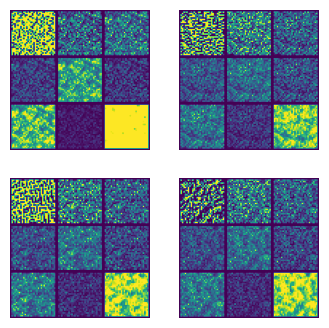

In [9]:
# test the model on a single sequence batch, generating new random images and states
x = tf.math.abs(tf.random.normal((4, 10, 32, 32, 1)))
h = tf.math.abs(tf.random.normal((4, 9)))
outConvSeq = sampleMod((x, h))
print(outConvSeq.shape)

# plot the average value of the elements of outConvSeq with pyplot
# plt.plot(tf.reduce_mean(outConvSeq, axis=(1, 2, 3)))

output = tf.transpose(outConvSeq, perm=[0, 1, 2])
#print(output.shape)
#for o in output:
#    print(np.mean(o))
#print("input h", tf.reduce_mean(h))

# generate a 4x32x32x1 image
imageBatch = tf.math.abs(tf.random.normal((1, 32, 32, 4)))
# show the 4 images in a 2x2 grid
# plt.figure(figsize=(4, 4))
# for i in range(4):
#     ax = plt.subplot(2, 2, i + 1)
#     plt.imshow(imageBatch[0, :, :, i])
#     plt.axis("off")
# plt.show()
convedSeq = []
initialFilter = tf.convert_to_tensor(initialFilter)
for i in range(9):
    if i == 0:
        filt = initialFilter
    else: 
        if i == 9:
            filt = output[-1]
        else:
            filt = output[i]
    conv_filter = tf.reshape(tf.transpose(filt), (3, 3, 1, 4))
    #print(conv_filter.shape)
    #print(imageBatch.shape)
    
    conv_output = tf.nn.convolution(imageBatch, conv_filter)
    # clamp the values to be between 0 and 1
    conv_output = tf.clip_by_value(conv_output, 0, 1)
    conv_output = tf.transpose(conv_output, perm=[3, 1, 2, 0])
    # shape (4, 30, 30, 1), expand to (4, 32, 32, 1) by adding a white border
    conv_output = tf.pad(conv_output, [[0, 0], [1, 1], [1, 1], [0, 0]], constant_values=0)
    convedSeq.append(conv_output)

convedSeq = tf.convert_to_tensor(convedSeq)
convedSeq = tf.transpose(convedSeq, perm=[1, 0, 2, 3, 4])
#print(convedSeq.shape)
# (4, 9, 32, 32, 1)

plt.figure(figsize=(4, 4))
for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.imshow(combine_images(convedSeq[i]))
    plt.axis('off')
plt.show()
